# WeatherNet

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import zipfile
import torch
import seaborn as sns
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms


In [2]:
print(torch.__version__)


2.3.1+cu121


In [3]:
path_rsc = './dataaets/dataset_rsc'
path_fog = '/dataaets/dataset_fog'

In [4]:
#zip_path_weather_image_recognition = './dataaets/weather-dataset.zip'
#zip_path_weather_detection_image_dataset = 'dataaets/потомскачаю'
#
#with zipfile.ZipFile(zip_path_weather_image_recognition, 'r') as zip_ref:
#    zip_ref.extractall('.')

Создаем свои кастомные датасэты

In [19]:
class rscDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.im_paths = [im_path for im_path in sorted(glob(f"{root_dir}/*/*.jpg"))]
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1



                
    def get_class(self, path): return os.path.basename(os.path.dirname(path))
    
    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transform is not None:
            im = self.transform(im)
        return im, gt
        
def get_dls(root,batch_size, transforms,  split=[0.8, 0.05, 0.1], ns=4):

    data = rscDataset(root_dir=root, transform=transform)
    total_len = len(data)
    train_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - (train_len + val_len)

    train_set, val_set, test_set = random_split(dataset=data, lengths=[train_len, val_len, test_len])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers = ns)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers = ns)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers = ns)

    return train_loader, val_loader, test_loader, data.cls_names


Задаем параметры

In [62]:
mean, std, img_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])
tr_dl, val_dl, test_dl, classes = get_dls(root = path_rsc, transforms = transform, batch_size = 16)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)


188
12
36
{'clear': 0, 'rain': 1, 'snow': 2}


Визуализация

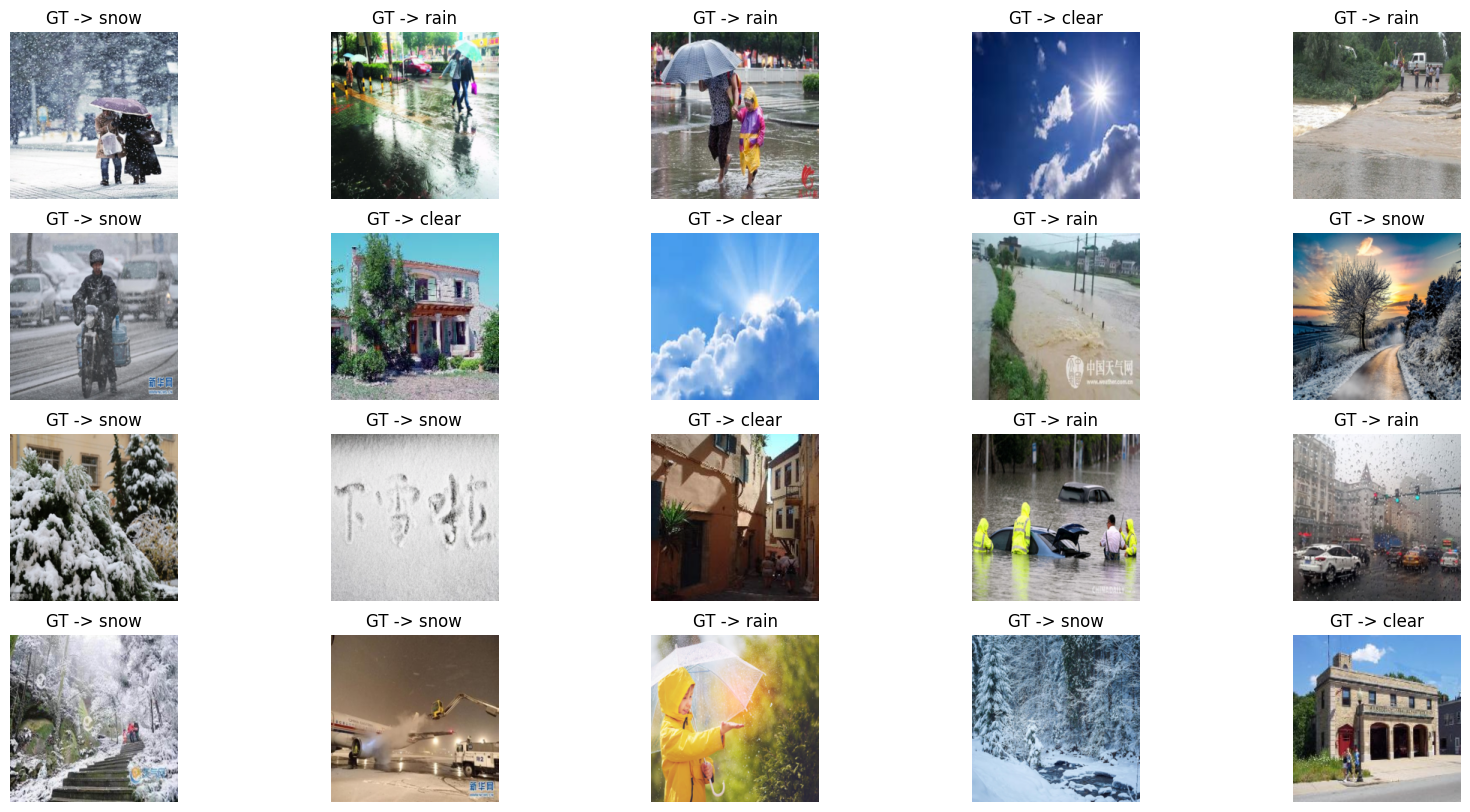

In [21]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = transforms.Compose([transforms.Normalize(mean = [ 0.], std = [1/0.5]), transforms.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

Настраиваем параметры

In [22]:
lr = 0.01
num_epochs = 10

Используем предобученную модель resnet50 из библиотеки timm

In [26]:
import timm
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m = timm.create_model("resnet50", pretrained = True, num_classes = len(classes))
m = m.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=m.parameters(), lr = lr)
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

save_prefix, save_dir = "weather", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5

for epoch in range(num_epochs):
    
    m.train()
    epoch_loss, epoch_acc = 0, 0
    for i, batch in tqdm(enumerate(tr_dl)):
    
        ims = batch[0].to(device)
        gts = batch[1].to(device)
        pred = m(ims)
        loss = loss_fn(pred, gts)
        
        epoch_loss += loss.item()
        epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        
    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track)
    
    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for i, batch in tqdm(enumerate(val_dl)):
            ims = batch[0].to(device)
            gts = batch[1].to(device)
            pred = m(ims)
            loss = loss_fn(pred, gts)

            pred_cls = torch.argmax(pred.data, dim = 1)
            val_epoch_loss += loss.item()
            val_epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
            
        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break
    

Start training...


188it [00:31,  6.03it/s]

1-epoch train process is completed!
1-epoch train loss          -> 0.794
1-epoch train accuracy      -> 0.673



12it [00:00, 13.79it/s]


1-epoch validation process is completed!
1-epoch validation loss     -> 0.510
1-epoch validation accuracy -> 0.797


188it [00:31,  5.98it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.623
2-epoch train accuracy      -> 0.743



12it [00:00, 13.72it/s]


2-epoch validation process is completed!
2-epoch validation loss     -> 0.513
2-epoch validation accuracy -> 0.813


188it [00:31,  6.02it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.549
3-epoch train accuracy      -> 0.778



12it [00:00, 13.33it/s]


3-epoch validation process is completed!
3-epoch validation loss     -> 0.437
3-epoch validation accuracy -> 0.840


188it [00:31,  5.97it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.498
4-epoch train accuracy      -> 0.807



12it [00:00, 13.36it/s]

4-epoch validation process is completed!
4-epoch validation loss     -> 0.585
4-epoch validation accuracy -> 0.749
Loss value did not decrease for 1 epochs



188it [00:31,  5.99it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.450
5-epoch train accuracy      -> 0.817



12it [00:00, 13.78it/s]

5-epoch validation process is completed!
5-epoch validation loss     -> 0.558
5-epoch validation accuracy -> 0.722
Loss value did not decrease for 2 epochs



188it [00:31,  5.98it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.397
6-epoch train accuracy      -> 0.849



12it [00:00, 13.29it/s]


6-epoch validation process is completed!
6-epoch validation loss     -> 0.364
6-epoch validation accuracy -> 0.872


188it [00:31,  5.93it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.373
7-epoch train accuracy      -> 0.859



12it [00:00, 13.82it/s]


7-epoch validation process is completed!
7-epoch validation loss     -> 0.355
7-epoch validation accuracy -> 0.861


188it [00:31,  5.91it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.337
8-epoch train accuracy      -> 0.875



12it [00:00, 13.96it/s]


8-epoch validation process is completed!
8-epoch validation loss     -> 0.318
8-epoch validation accuracy -> 0.904


188it [00:32,  5.85it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.329
9-epoch train accuracy      -> 0.882



12it [00:00, 14.03it/s]

9-epoch validation process is completed!
9-epoch validation loss     -> 0.655
9-epoch validation accuracy -> 0.711
Loss value did not decrease for 3 epochs



188it [00:32,  5.81it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.320
10-epoch train accuracy      -> 0.883



12it [00:00, 13.42it/s]

10-epoch validation process is completed!
10-epoch validation loss     -> 0.496
10-epoch validation accuracy -> 0.807
Loss value did not decrease for 4 epochs


In [8]:
print(torch.cuda.is_available())

True


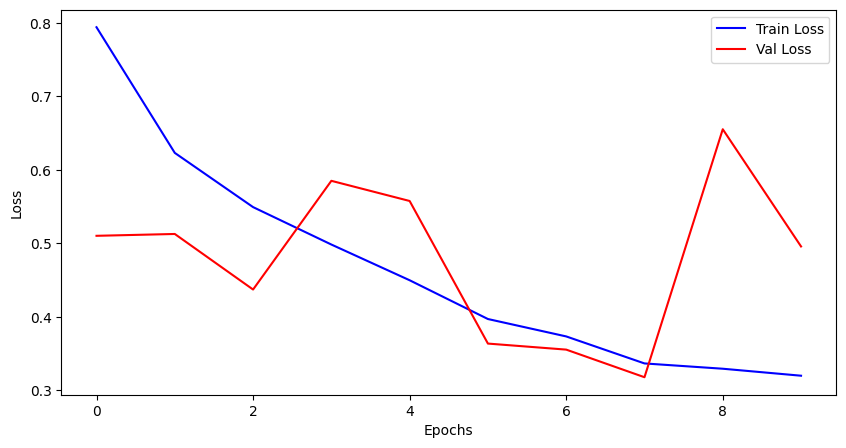

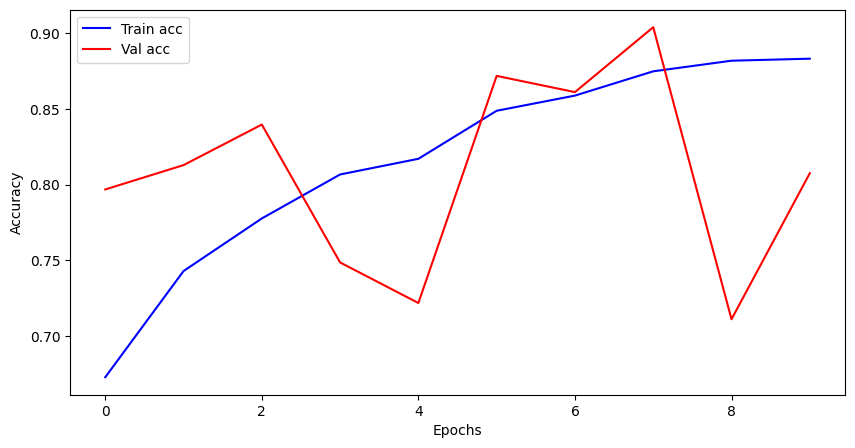

In [59]:
plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
sns.lineplot(x=num_epochs, y=tr_losses, label = "Train Loss", c = "blue")
sns.lineplot(x=num_epochs, y=val_losses, label = "Val Loss", c = "red")
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
sns.lineplot(x=num_epochs, y=tr_accs, label = "Train acc", c = "blue")
sns.lineplot(x=num_epochs, y=val_accs, label = "Val acc", c = "red")
plt.show()



Тестовая выборка

In [68]:
test_loss, test_accs = [], []

m.eval()
with torch.no_grad():
    test_epoch_loss, test_epoch_acc = 0, 0
    for i, batch in tqdm(enumerate(test_dl)):
        ims = batch[0].to(device)
        gts = batch[1].to(device)
        pred = m(ims)
        loss = loss_fn(pred, gts)

        pred_cls = torch.argmax(pred.data, dim = 1)
        test_epoch_loss += loss.item()
        test_epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
        
    test_loss_to_track = test_epoch_loss / len(test_dl)
    test_acc_to_track = test_epoch_acc / len(test_dl.dataset)
    test_losses.append(test_loss_to_track); test_accs.append(test_acc_to_track)

    print(f"{epoch + 1}-epoch validation process is completed!")
    print(f"{epoch + 1}-epoch validation loss     -> {test_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch validation accuracy -> {test_acc_to_track:.3f}")

36it [00:02, 15.84it/s]

10-epoch validation process is completed!
10-epoch validation loss     -> 0.338
10-epoch validation accuracy -> 0.862
